In [1]:
import numpy as np
import matplotlib.pylab as plt
from __future__ import division

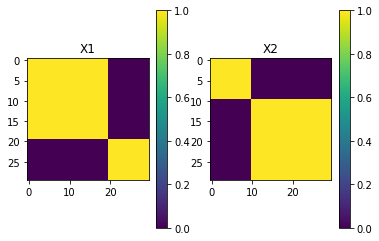

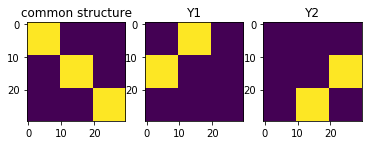

In [7]:
Psi=np.asarray([
    [.770,.072],
    [.072,.670]
])

Z1_gt=np.asarray([1,0]*20+[0,1]*10).reshape(30,2)
Mz1=Z1_gt.dot(Psi).dot(Z1_gt.T)
X1_gt=Z1_gt.dot(Z1_gt.T)

Z2_gt=np.asarray([1,0]*10+[0,1]*20).reshape(30,2)
Mz2=Z2_gt.dot(Psi).dot(Z2_gt.T)
X2_gt=Z2_gt.dot(Z2_gt.T)

C_gt=X1_gt*X2_gt
Y1=X1_gt-C_gt
Y2=X2_gt-C_gt

plt.subplot(121)
plt.title('X1')
plt.imshow(X1_gt)
plt.colorbar()

plt.subplot(122)
plt.title('X2')
plt.imshow(X2_gt)
plt.colorbar()
plt.show()

plt.figure(1)
plt.subplot(131)
plt.title('common structure')
plt.imshow(C_gt)

plt.subplot(132)
plt.title('Y1')
plt.imshow(Y1)

plt.subplot(133)
plt.title('Y2')
plt.imshow(Y2)
plt.show()

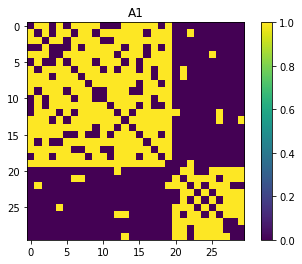

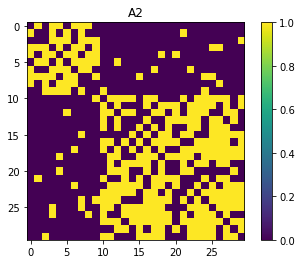

In [8]:
A1=np.random.binomial(1,Mz1)
# A1=np.triu(A1)+np.triu(A1).T-1*np.diag(np.diag(A1))
A1=np.triu(A1)+np.triu(A1).T-2*np.diag(np.diag(A1))
plt.figure(2)
plt.title('A1')
plt.imshow(A1)
plt.colorbar()
plt.show()
lamb1=2/(A1.shape[0]*(A1.shape[0]-1))*np.sum(np.triu(A1)-np.diag(np.diag(A1)))

A2=np.random.binomial(1,Mz2)
# A2=np.triu(A2)+np.triu(A2).T-1*np.diag(np.diag(A2))
A2=np.triu(A2)+np.triu(A2).T-2*np.diag(np.diag(A2))
plt.figure(2)
plt.title('A2')
plt.imshow(A2)
plt.colorbar()
plt.show()
lamb2=2/(A2.shape[0]*(A2.shape[0]-1))*np.sum(np.triu(A2)-np.diag(np.diag(A2)))

In [9]:
def proj_simplex(v, s=1):
    n = v.shape[0]
    if v.sum() == s and np.alltrue(v >= 0):
        return v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    theta = float(cssv[rho] - s) / rho
    w = (v - theta).clip(min=0)
    return w

def proj_l1(v, s=1):
    n = v.shape[0]
    u = np.abs(v)
    if u.sum() <= s:
        return v
    w = proj_simplex(u, s=s)
    w *= np.sign(v)
    return w

def proj_1inf(Y,lamb):
    res=np.zeros((Y.shape))
    for i in range(Y.shape[0]):
        res[i,:]=Y[i,:]-proj_l1(Y[i,:],lamb)
    return res

def proj_A(X):
    n=X.shape[0]
    temp1=np.append((X-np.diag(np.diag(X))).dot(np.ones(n))*2,np.diag(X))-b
    mu1,nu1=temp1[:n],temp1[n:]
    temp2=np.append(1/(2*(n-2))*(mu1-np.ones(n)*(np.sum(mu1)/(2*n-2))),nu1)
    mu2,nu2=temp2[:n],temp2[n:]
    temp=np.outer(mu2,np.ones(n))
    res=X-((temp+temp.T-2*np.diag(mu2))+np.diag(nu2))
    return res

def proj_psd(X):
    w,v=np.linalg.eig((X+X.T)/2)
    idx=(w>=0)
    res=v[:,idx].dot(np.diag(w[idx])).dot(v[:,idx].T)
    return res
    

0 -iter
2.8918105422588383


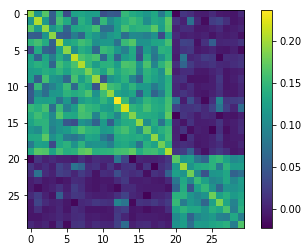

10 -iter
1.3372598864468104


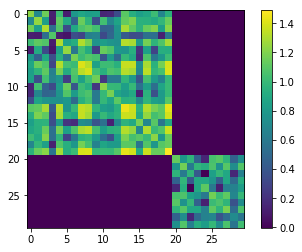

20 -iter
0.6272077313531688


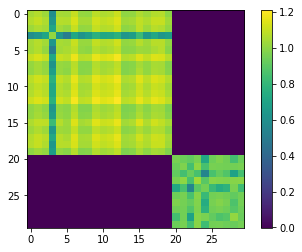

30 -iter
0.36998931818943925


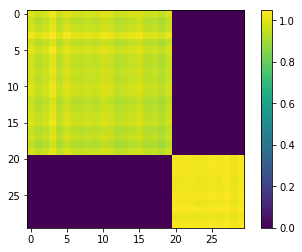

40 -iter
0.25023919262054034


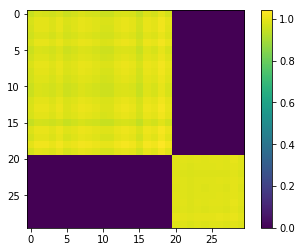

50 -iter
0.12646757864158917


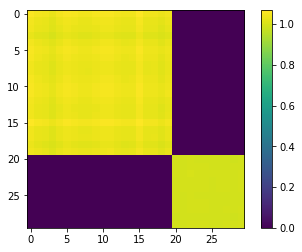

60 -iter
0.1363278610426012


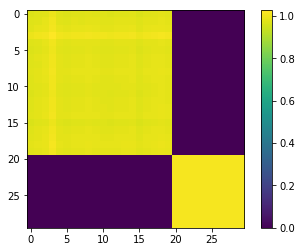

70 -iter
0.08936599161106666


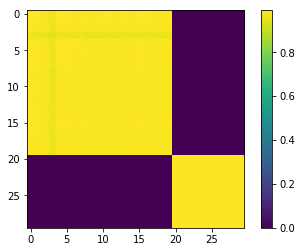

80 -iter
0.037623110328934305


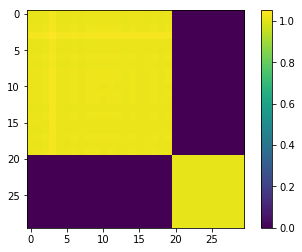

90 -iter
0.08551082625649524


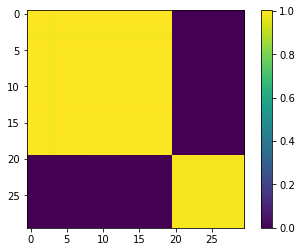

100 -iter
0.031161581960936185


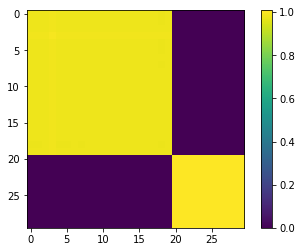

110 -iter
0.05041208509678534


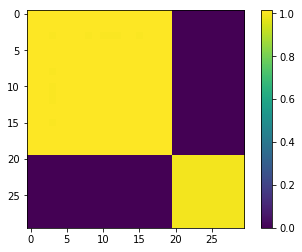

120 -iter
0.05494123949161141


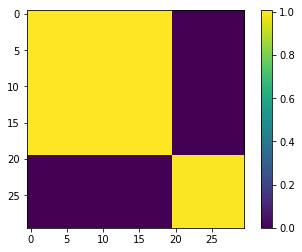

130 -iter
0.012153196897275427


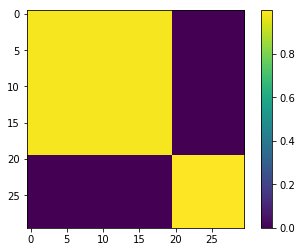

140 -iter
0.04375532093145935


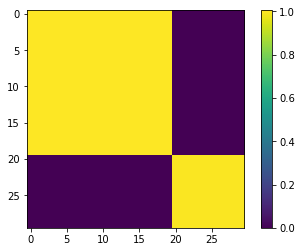

150 -iter
0.0261360285344252


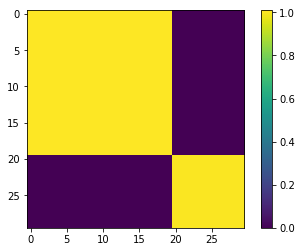

160 -iter
0.016865264176519113


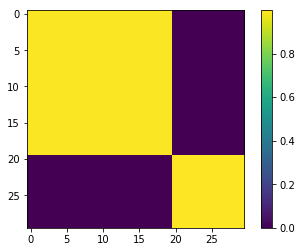

170 -iter
0.030752351182449816


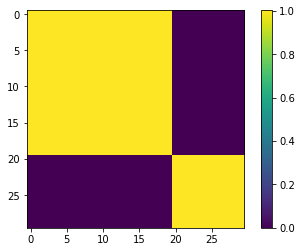

180 -iter
0.007036452893749801


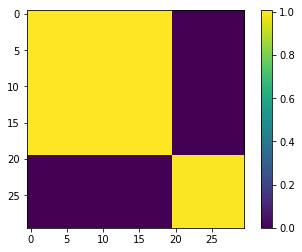

190 -iter
0.01940601618355823


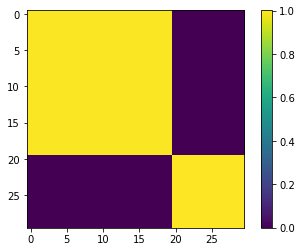

200 -iter
0.018036271505720798


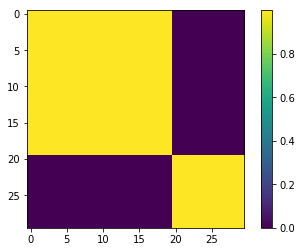

210 -iter
0.003657322292938973


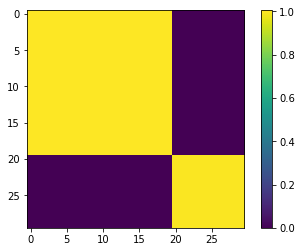

220 -iter
0.01616802158422569


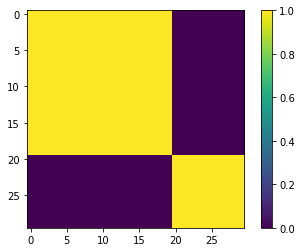

227 -iter(last)
0.00024067703359277834


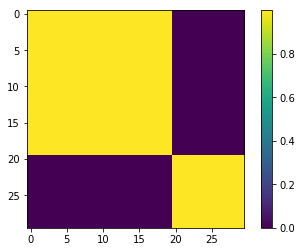

In [19]:
n,K=Z1_gt.shape
b=np.ones(n)
max_iter=int(1e4)
C=-(A1-lamb1*np.ones((n,n)))
# -lamb1*np.ones((n,n))

X=np.zeros((A1.shape[0],A1.shape[1]))
S=np.zeros((A1.shape[0],A1.shape[1]))
Z=np.zeros((A1.shape[0],A1.shape[1]))
v=np.zeros(n)
y=np.zeros(n)
s=np.zeros(n)

rho=.2
tau=1.5
tol=1e-3
for it in range(max_iter):
    X_old=X
    R1=np.diag(y)+S+Z-C+X/rho
    R2=v-y+s/rho
    Z=np.minimum(np.maximum(0,rho*(R1-Z))/rho-(R1-Z),1)
    v=np.minimum(b,rho*(R2-v))/rho-(R2-v)
    y=0.5*(v+s/rho-np.diag(S+Z-C+X/rho))
    R1=np.diag(y)+S+Z-C+X/rho
    S=proj_psd(S-R1)
    X=X+tau*rho*(np.diag(y)+S+Z-C)
    s=s+tau*rho*(v-y)
    if(np.linalg.norm(X-X_old)<tol):
        break
    if(it%10==0):
        print(it,'-iter')
        print(np.linalg.norm(X-X_old))
        plt.figure(3)
        plt.imshow(X)
        plt.colorbar()
        plt.show()
print(it,'-iter(last)')
print(np.linalg.norm(X-X_old))
plt.figure(3)
plt.imshow(X)
plt.colorbar()
plt.show()
X1_opt=X


0 -iter
1.4232113357547271


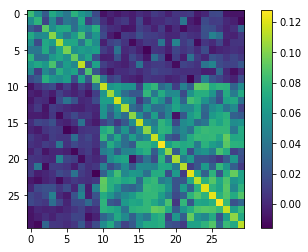

10 -iter
0.9329204747711448


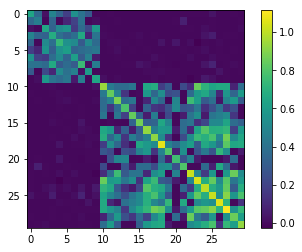

20 -iter
0.4121270542808072


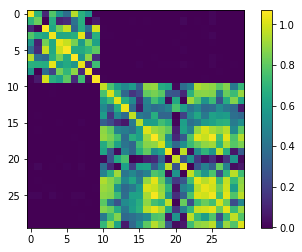

30 -iter
0.26373919349870867


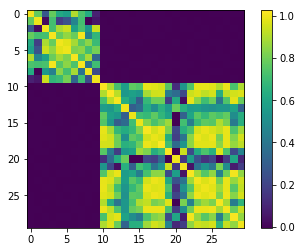

40 -iter
0.19901666078803765


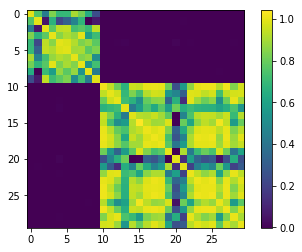

50 -iter
0.13654979093214525


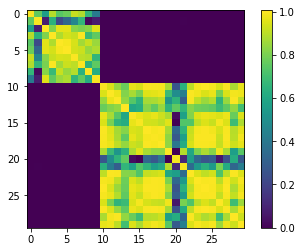

60 -iter
0.1012441457641692


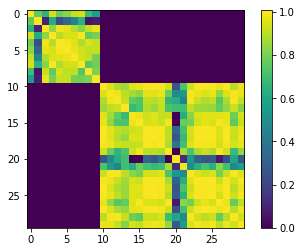

70 -iter
0.08276978529116641


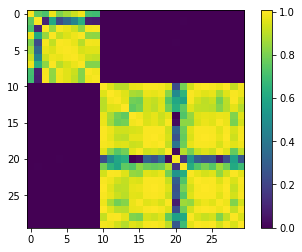

80 -iter
0.06314446119537895


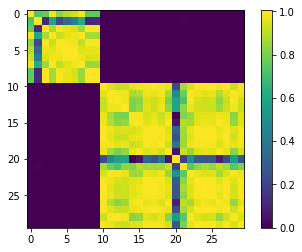

90 -iter
0.05534664379101906


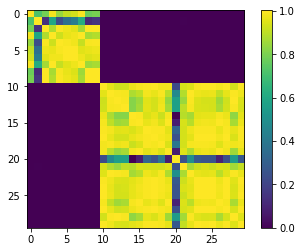

100 -iter
0.046673352639879734


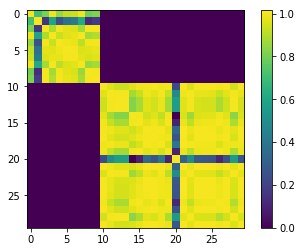

110 -iter
0.03206482100321732


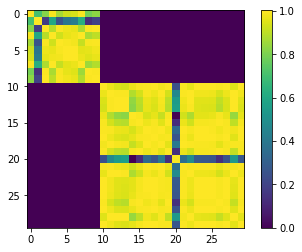

120 -iter
0.019188385461243324


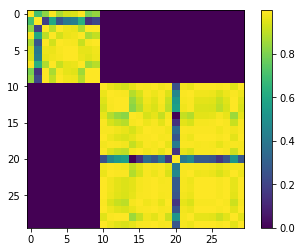

130 -iter
0.01389662749376117


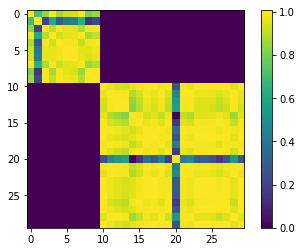

140 -iter
0.009504139421925729


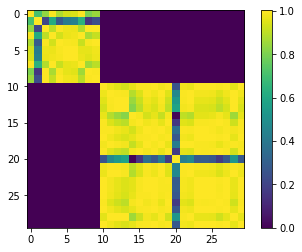

150 -iter
0.005443159045199535


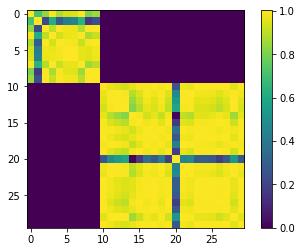

160 -iter
0.004499726749451234


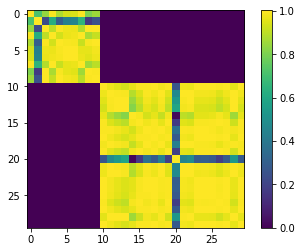

170 -iter
0.004087566356379873


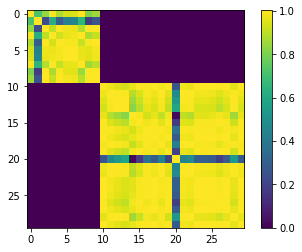

180 -iter
0.002970297461455018


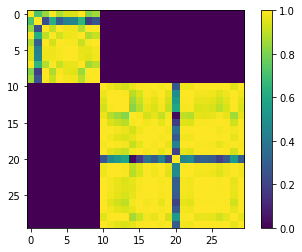

190 -iter
0.0025976313779265815


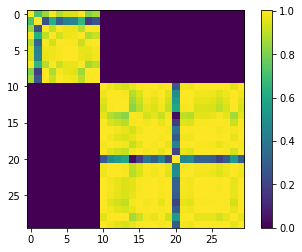

200 -iter
0.0024339745800949445


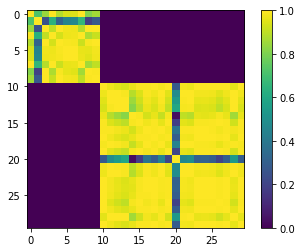

210 -iter
0.002046941025036965


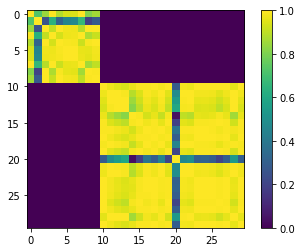

220 -iter
0.0017877509738899128


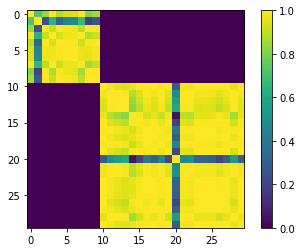

230 -iter
0.0016386862391967669


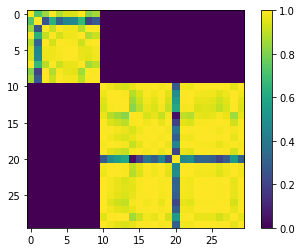

240 -iter
0.0014508060226541483


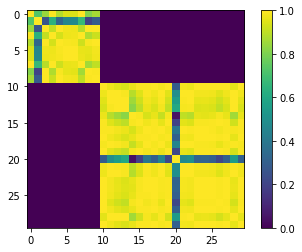

250 -iter
0.0012823304221040825


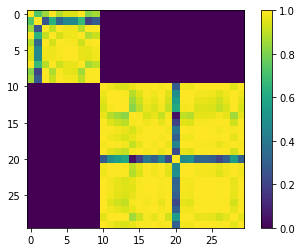

260 -iter
0.0011591995657946504


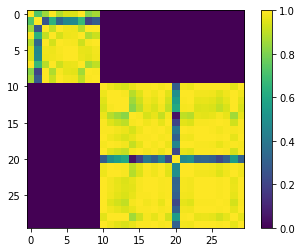

270 -iter
0.0010391383648988772


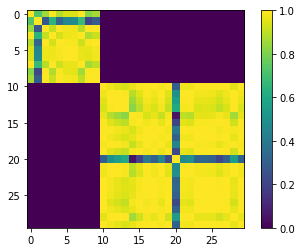

274 -iter(last)
0.0009946257446664716


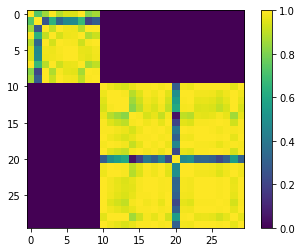

In [22]:
n,K=Z2_gt.shape
b=np.ones(n)
max_iter=int(1e4)
C=-(A2-lamb2*np.ones((n,n)))
# -lamb2*np.ones((n,n))

X=np.zeros((A2.shape[0],A2.shape[1]))
S=np.zeros((A2.shape[0],A2.shape[1]))
Z=np.zeros((A2.shape[0],A2.shape[1]))
v=np.zeros(n)
y=np.zeros(n)
s=np.zeros(n)

rho=.1
tau=1.5
tol=1e-3
for it in range(max_iter):
    X_old=X
    R1=np.diag(y)+S+Z-C+X/rho
    R2=v-y+s/rho
    Z=np.minimum(np.maximum(0,rho*(R1-Z))/rho-(R1-Z),1)
    v=np.minimum(b,rho*(R2-v))/rho-(R2-v)
    y=0.5*(v+s/rho-np.diag(S+Z-C+X/rho))
    R1=np.diag(y)+S+Z-C+X/rho
    S=proj_psd(S-R1)
    X=X+tau*rho*(np.diag(y)+S+Z-C)
    s=s+tau*rho*(v-y)
    if(np.linalg.norm(X-X_old)<tol):
        break
    if(it%10==0):
        print(it,'-iter')
        print(np.linalg.norm(X-X_old))
        plt.figure(3)
        plt.imshow(X)
        plt.colorbar()
        plt.show()
print(it,'-iter(last)')
print(np.linalg.norm(X-X_old))
plt.figure(3)
plt.imshow(X)
plt.colorbar()
plt.show()
X2_opt=X

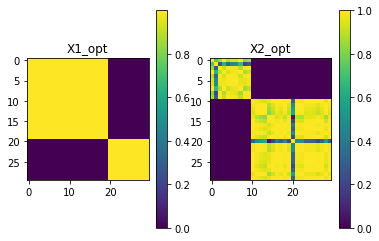

C:\Users\kianx\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


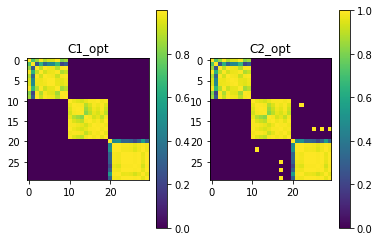

In [23]:
plt.figure(3)
plt.subplot(121)
plt.title('X1_opt')
plt.imshow(X1_opt)
plt.colorbar()

plt.subplot(122)
plt.title('X2_opt')
plt.imshow(X2_opt)
plt.colorbar()
plt.show()

C_opt=np.vstack((np.ravel(X1_opt),np.ravel(X2_opt))).T
C_opt=proj_1inf(C_opt,1).T
C1_opt=C_opt[0,:].reshape(n,n)
C2_opt=C_opt[1,:].reshape(n,n)

plt.figure(3)
plt.subplot(121)
plt.title('C1_opt')
plt.imshow(C1_opt)
plt.colorbar()

plt.subplot(122)
plt.title('C2_opt')
plt.imshow(C2_opt)
plt.colorbar()
plt.show()

0 -iter
1.2139438086774565


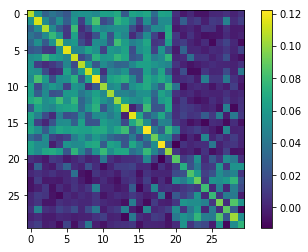

10 -iter
1.091006637183422


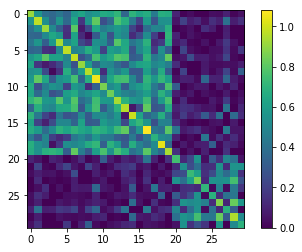

20 -iter
0.6550459594116903


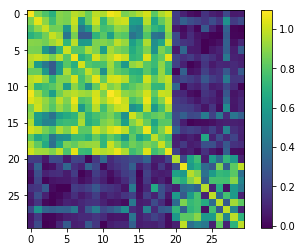

30 -iter
0.4224574194821663


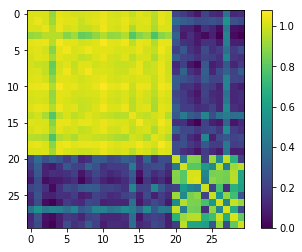

40 -iter
0.2236382025092861


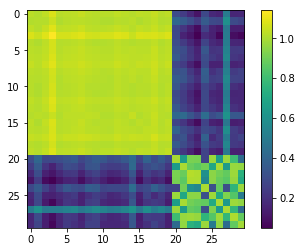

50 -iter
0.17506092522441322


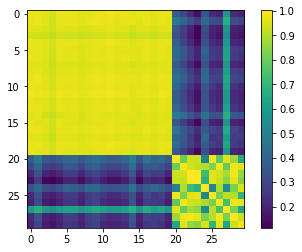

60 -iter
0.1950084041535636


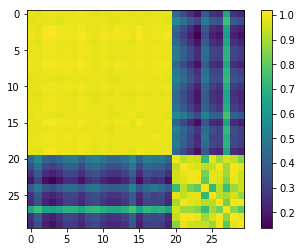

70 -iter
0.1275964618842741


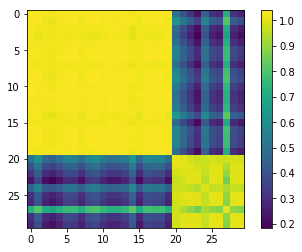

80 -iter
0.1424916906067755


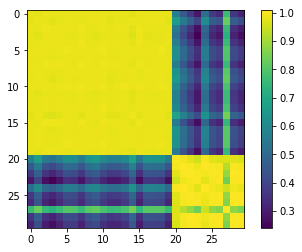

90 -iter
0.12546076594484637


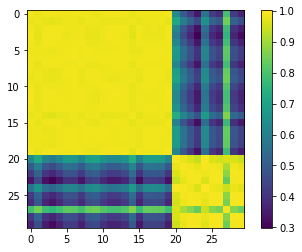

100 -iter
0.10158222484025914


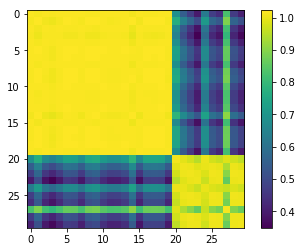

101 -iter(last)
0.09967553356085412


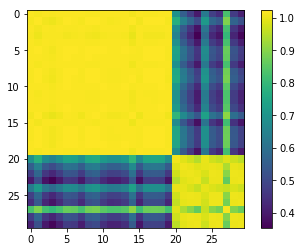

101 -iter(last)
0.0


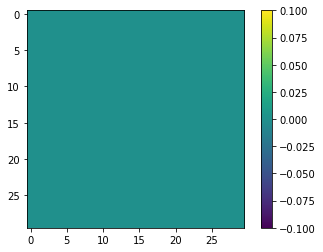

C:\Users\kianx\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [93]:
n,K=Z1_gt.shape
b=np.ones(n)
max_iter=int(5e2)
C1=-(A1)
C2=-(A2)

X1=np.zeros((A1.shape[0],A1.shape[1]))
S1=np.zeros((A1.shape[0],A1.shape[1]))
Z1=np.zeros((A1.shape[0],A1.shape[1]))
v1=np.zeros(n)
y1=np.zeros(n)
s1=np.zeros(n)

X2=np.zeros((A2.shape[0],A2.shape[1]))
S2=np.zeros((A2.shape[0],A2.shape[1]))
Z2=np.zeros((A2.shape[0],A2.shape[1]))
v2=np.zeros(n)
y2=np.zeros(n)
s2=np.zeros(n)


rho=.05
tau=1.5
tol=1e-1
for it in range(max_iter):
    X1_old=X1
    R1=np.diag(y1)+S1+Z1-C1+X1/rho
    R2=v1-y1+s1/rho
    Z1=np.maximum(0,rho*(R1-Z1))/rho-(R1-Z1)
    v1=np.minimum(b,rho*(R2-v1))/rho-(R2-v1)
    y1=0.5*(v1+s1/rho-np.diag(S1+Z1-C1+X1/rho))
    R1=np.diag(y1)+S1+Z1-C1+X1/rho
    S1=proj_psd(S1-R1)
    X1=X1+tau*rho*(np.diag(y1)+S1+Z1-C1)
    s1=s1+tau*rho*(v1-y1)
    if(np.linalg.norm(X1-X1_old)<tol):
        break
    if(it%10==0):
        print(it,'-iter')
        print(np.linalg.norm(X1-X1_old))
        plt.figure(3)
        plt.imshow(X1)
        plt.colorbar()
        plt.show()

#     X2_old=X2
#     R1=np.diag(y2)+S2+Z2-C2+X2/rho
#     R2=v2-y2+s2/rho
#     Z2=np.maximum(0,rho*(R1-Z2))/rho-(R1-Z2)
#     v2=np.minimum(b,rho*(R2-v2))/rho-(R2-v2)
#     y2=0.5*(v2+s2/rho-np.diag(S2+Z2-C2+X2/rho))
#     R1=np.diag(y2)+S2+Z2-C2+X2/rho
#     S2=proj_psd(S2-R1)
#     X2=X2+tau*rho*(np.diag(y2)+S2+Z2-C2)
#     s2=s2+tau*rho*(v2-y2)
#     if(np.linalg.norm(X2-X2_old)<tol):
#         break
#     if(it%10==0):
#         print(it,'-iter')
#         print(np.linalg.norm(X2-X2_old))
#         plt.figure(3)
#         plt.imshow(X2)
#         plt.colorbar()
#         plt.show()
#     X=np.vstack((np.ravel(X1),np.ravel(X2))).T
#     X=proj_1inf(X,1).T
#     X1=X[0,:].reshape(n,n)
#     X2=X[1,:].reshape(n,n)
    
#     if(it%10==0):
#         print(it,'-iter')
#         plt.figure(3)
#         plt.imshow(X1)
#         plt.colorbar()
#         plt.show()
    
# print(it,'-iter(last)')
# print(np.linalg.norm(X1-X1_old))
# plt.figure(3)
# plt.imshow(X1)
# plt.colorbar()
# plt.show()
# X1_opt=X1

# print(it,'-iter(last)')
# print(np.linalg.norm(X2-X2_old))
# plt.figure(3)
# plt.imshow(X2)
# plt.colorbar()
# plt.show()
# X2_opt=X2






# C_opt=np.vstack((np.ravel(X1_opt),np.ravel(X2_opt))).T
# C_opt=proj_1inf(C_opt,1).T
# C1_opt=C_opt[0,:].reshape(n,n)
# C2_opt=C_opt[1,:].reshape(n,n)